# Causal estimation with ```cause2e```
This notebook shows how ```cause2e``` can be used for estimating quantitative causal effects from our data, once we have recovered the causal graph. The core functionality is provided by the ```DoWhy``` package, but ```cause2e``` adds some helpful functionality for a more straightforward analysis of multiple causal effects.

### Imports
Since the causal graph is assumed to be known, we only need estimation methods.

In [1]:
import os
from IPython.display import Image
from cause2e import path_mgr, estimator

## Set up paths to data and output directories
This step is conveniently handled by the ```PathManager``` class, which avoids having to wrestle with paths throughout the multistep causal analysis. If we want to perform the analysis in a directory ```'dirname'``` that contains ```'dirname/data'``` and ```'dirname/output'``` as subdirectories, we can also use ```PathManagerQuick``` for an even easier setup. The experiment name is used for generating output files with meaningful names, in case we want to study multiple scenarios (e.g. with varying model parameters).

In [2]:
cwd = os.getcwd()
wd = os.path.dirname(cwd)
paths = path_mgr.PathManager(experiment_name='linear_test',
                             data_name='linear_test.csv',
                             data_dir=os.path.join(wd, 'data'),
                             output_dir=os.path.join(wd, 'sample_output')
                             )

## Problem statement
Let us shortly assess the situation: We want to analyze the causal effect of a variable ```v``` on another variable ```y```. As a result of our previous structure learning efforts, we have found that there are four confounders that influence both variables, as is shown in the below graph. Since the data has been synthetically generated using the ```DataGenerator``` class, we also know that the true causal effect is 2. The goal now is to recover this effect from the data and the graph in a principled way that generalizes to more complicated scenarios.

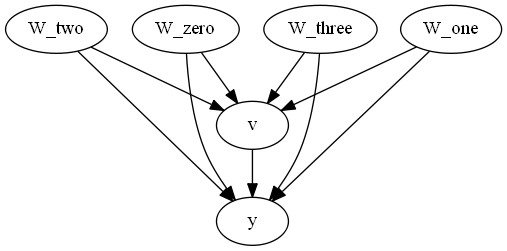

In [3]:
Image(paths.png_name)

## Estimate causal effects from the graph and the data
After we have successfully recovered the causal graph from data and domain knowledge, we can use it to estimate quantitative causal effects between the variables in the graph. It is pleasant that we can use the same graph and data to estimate multiple causal effects, e.g. the one that ```v``` has on ```y```, as well as the one that ```W_one``` has on ```v```, without having to repeat the previous steps. Once we have managed to qualitatively model the data generating process, we are already in a very good position. The remaining challenges can be tackled with the core functionality from the ```DoWhy``` package and some helper methods that make the transition from learning the graph to using it for estimation less cumbersome.

### Create an Estimator
The ```Estimator``` class is mainly a wrapper around methods of the ```DoWhy``` package. It helps us in performing a principled and modular estimation of causal effects from data and a given causal graph.

In [4]:
estim = estimator.Estimator(paths)

### Read the data
We read the data from the csv that was generated by the ```DataGenerator```.

In [5]:
estim.read_csv(index_col=0)

In [6]:
estim.variables

{'W0', 'W1', 'W2', 'W3', 'v0', 'y'}

### Preprocess the data
The raw data is often not suited as immediate input to machine learning algorithms, so we provide some preprocessing facilities: Adding, deleting, renaming and recombining variables is possible. In this example, we demonstrate the possibility to rename some variables, which is necessary to match the slightly different names of the variables in the causal graph.

In [7]:
name_change = {'v0': 'v',
               'W0': 'W_zero',
               'W1': 'W_one',
               'W2': 'W_two',
               'W3': 'W_three'
               }
for current_name, new_name in name_change.items():
    estim.rename_variable(current_name, new_name)

### Estimate an effect via a quick analysis
```Cause2e``` provides the possibility to estimate causal effects without any parameter tuning or model selection. If we have the causal graph, the package internally identifies a causal estimand via do-calculus and then estimates it with linear regression methods. For more advanced settings, e.g. in a non-linear case, check out the rest of the notebook.

In [8]:
estim.run_quick_analysis('v', 'y', 'nonparametric-ate')

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

## Realized estimand
b: y~v+W_two+W_three+W_zero+W_one
Target units: ate


We see that the causal effect of ```v``` on ```y``` has correctly estimated to be 2. The output also lets us see that the backdoor criterion was used for eliminating the influence of confounders, and the linear regression equation was used for the quantitative estimation.

### Access results of quick analyses
If we want to revisit the result of the analysis at a later stage, we can call ```show_quick_results```.

In [9]:
estim.show_quick_results()

Only quantitative estimates are shown. For methodic details, use Estimator.show_quick_result_methods.

Average treatment effects from quick analyses:

          Estimated_effect
Outcome                  y
Treatment                 
v                 2.000019


Natural direct effects from quick analyses:

Empty DataFrame
Columns: []
Index: []


Natural indirect effects from quick analyses:

Empty DataFrame
Columns: []
Index: []
Saving all causal estimates from quick analyses to csv.



As indicated by the output, we can not only query the quantitative result, but also the methods that were used to obtain it.

In [10]:
estim.show_quick_result_methods('v', 'y', 'nonparametric-ate')

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

## Realized estimand
b: y~v+W_two+W_three+W_zero+W_one
Target units: ate


It is also possible to erase the results of our previous analyses if we have made a mistake and want to start from scratch.

In [11]:
estim.erase_quick_results()

### Run multiple quick analyses
If we are not only interested in one specific causal effect, but in a holistic causal analysis of the data generating process, we can automatically perform multiple quick analyses via the ```run_multiple_quick_analyses``` method that lets us specify all treatments, outcomes and effect types of interest. In most cases, we can just analyse all the possible combinations, in order not to miss any interesting causal finding.

Showing and saving heatmaps of the causal estimates.



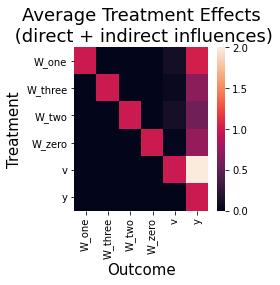

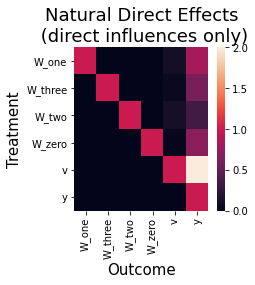

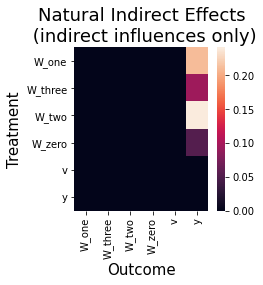


10 Largest Average Treatment Effects
 (direct + indirect influences):
   Treatment Outcome Estimated_effect
57         v       y             2.00
93     W_one       y             1.03
39    W_zero       y             0.75
3    W_three       y             0.71
75     W_two       y             0.59
81     W_two       v             0.12
99     W_one       v             0.11
9    W_three       v             0.05
45    W_zero       v             0.03
6    W_three  W_zero             0.00


10 Largest Natural Direct Effects
 (direct influences only):
    Treatment Outcome Estimated_effect
58          v       y             2.00
94      W_one       y             0.82
40     W_zero       y             0.70
4     W_three       y             0.61
76      W_two       y             0.34
82      W_two       v             0.12
100     W_one       v             0.11
10    W_three       v             0.05
46     W_zero       v             0.03
7     W_three  W_zero             0.00


10 Largest Natura

In [12]:
estim.run_all_quick_analyses()

The resulting heatmaps visualize all overall, direct and indirect causal effects that a given treatment variable has on a given outcome variable. We see that all the ```W``` variables are not influenced by any variables, but they have causal effects on ```v``` and ```y```. Since the colors are not easy to interpret if we are looking for the exact strengths of the respective effects, we can look at the numeric tables below that list all of them. We can also show the heatmaps via ```estim.show_heatmaps()``` and the numeric tables via ```estim.show_quick_results()``` without recalculating the effects. Both methods provide a ```save``` argument that we can set to ```False``` if no saving is required.

### Generate a pdf report
The data is already written to csv and png files when we perform the analyses, but it is helpful to have all the information in one place.
```Cause2e``` can generate a pdf report that contains
- the causal graph indicating all qualitative relationships,
- the three heatmaps visualizing all quantitative causal effects,
- the results of optional validations (see the minimal end-to-end analysis notebook for an example),
- the three numeric tables reporting all quantitative causal effects.

This is helpful if we want to communicate our findings to other people, or if we want to modify the analysis at a later time and compare the outcome for both methods.

In [13]:
estim.generate_pdf_report()

Successfully generated report in c:\Users\D.Gruenbaum\Desktop\local_cause2e\cause2e\sample_output\linear_test_report.pdf.



## Looking under the hood of causal estimation
The quick analysis functionality is very convenient, but for some analyses we need more flexibility in choosing the right estimation methods. It is then helpful to perform the more fine-grained steps of initializing a causal model, identifying a causal estimand, estimating the estimand and performing robustness checks, as proposed by the creators of the ```DoWhy``` package that is internally used by ```cause2e```.

### Initialize the causal model
This is the step where we decide which specific effect we want to analyze. We are interested in estimating the effect of ```v``` on ```y```. ```DoWhy``` conveniently lets us choose between different types of causal effects (overall average treatment effect vs. more specific direct and indirect treatment effects in a mediation analysis).

In [14]:
estim.initialize_model(treatment='v',
                       outcome='y',
                       estimand_type="nonparametric-ate"
                       )

### Identify estimands for the causal effect
The big advantage of model-based causal inference is that once we have the causal graph, a statistical estimand for a specified causal effect (e.g. ```v``` on ```y```) can be derived by purely algebraic methods (Pearl's do-calculus). The estimand (verbally translated: "the thing that is to be estimated") does not tell us in numbers what the causal effect is, but it is more like an algebraic recipe for estimating the quantity of interest. In our case, the do-calculus tells us that a certain type of backdoor adjustment is the way to go, and the key assumptions for drawing this conclusion are explicitly stated right after a mathematical expression of the estimand. Depending on the graph structure, instrumental variable or frontdoor adjustment strategies can also work, but in this case no valid estimand can be derived using these strategies. The sole argument of the method serves to silence ```DoWhy```'s prompting of a user input that must be answered with 'yes' anyway and causes problems in non-interactive development settings.

In [15]:
estim.identify_estimand(proceed_when_unidentifiable=True)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### Estimate the causal effect
Now that we know what to estimate, we can focus on the how. For this example, we demonstrate the use of a simple linear regression estimator, but there are many more possibilities documented in [this notebook](https://microsoft.github.io/dowhy/example_notebooks/dowhy_estimation_methods.html) provided by the creators of ```DoWhy```. Using the estimand from the last step, the package knows which covariates should be included as inputs of the linear regression. The result shows that the estimate is very close to the true value of the causal effect (```beta=2```). The additional output summarizes all decisions that we have taken in order to arrive at this value.

In [16]:
estim.estimate_effect(verbose=True,
                      method_name='backdoor.linear_regression'
                      )

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

## Realized estimand
b: y~v+W_two+W_three+W_zero+W_one
Target units: ate

## Estimate
Mean value: 2.000019001072226



### Perform robustness checks
After we have estimated the causal effect, performing robustness checks can lend additional credibility to our final estimate. DoWhy provides several such checks called 'refuters' that are explained [here](https://microsoft.github.io/dowhy/readme.html#iv-refute-the-obtained-estimate). As an example, we check that the estimate is robust to adding an independent random variable as a common cause to the dataset.

In [17]:
estim.check_robustness(verbose=True,
                       method_name='random_common_cause'
                       )

Refute: Add a Random Common Cause
Estimated effect:2.000019001072226
New effect:2.00001733159899



## Compare the results to a non-causal regression analysis
Without the causal framework, causal effects are often estimated by running a linear regression with the outcome (```y```) as target variable and the treatment (```v```) and possibly other covariates as input variables. The causal effect is then assumed to be the coefficient associated with the treatment variable in the resulting regression equation. In order to assess what we have actually gained by applying all the causal machinery in this notebook, it can be helpful to compare our causal estimate of the effect to the regression-based method. We see that a regression analysis with only ```v``` as input fails to estimate the correct causal effect. This is not surprising, given that it neglects all 4 confounders.

In [18]:
estim.compare_to_noncausal_regression(input_cols={'v'})

Regression score: 0.5303668144727591
--------------------------------
Regression coefficients:
('v', 2.8032661160892354)
Intercept: [0.7591823]
--------------------------------
Causal estimate for effect of v on y: 2.000019001072226
Regression estimate for effect of v on y: 2.8032661160892354


The situation changes if we select all variables except for ```y``` as input to the linear regression. Up to a small numerical error, the result is identical to the causal estimate that we have gained after lots of hard work. Again, this is not a surprise if we look at the "Realized estimand" in the causal estimation step, showing that we use the exact same linear regression in both approaches.

In [19]:
estim.compare_to_noncausal_regression(input_cols={'y'}, drop_cols=True)

Regression score: 0.9999686812225519
--------------------------------
Regression coefficients:
('W_zero', 0.6952167803479535)
('W_one', 0.8207689669593912)
('W_two', 0.3438901797700753)
('W_three', 0.6107458226577794)
('v', 2.000019001072238)
Intercept: [-4.82476438e-05]
--------------------------------
Causal estimate for effect of v on y: 2.000019001072226
Regression estimate for effect of v on y: 2.000019001072238


## Final thoughts
After this comparison, we might ask ourselves: Was it worth all the trouble to arrive at the same result that we could have gotten with a simple linear regression? The answer is subtle: In principle, we can always guess the correct input variables for a (possibly nonlinear) regression that will allow us to estimate the desired causal effect.

The problem is that 
- we must be at the same time domain experts and statistical experts to take the right decisions
- there is no principled way to decide if a variable should be a regression input or not, so it will ultimatively always come down to justifying it with "gut feeling". There are many situations where simply including all the covariates as inputs will be as misleading as not including any covariates except for the treatment itself and only a carefully chosen subset of the variables will lead to the correct causal estimate.
- many underlying causal graphs are just too complex to be disentangled by humans. How would you choose correct backdoor (let alone frontdoor) adjustment sets in a problem with 100 variables without even having the causal graph as an explicit representation?

The causal framework on the other hand provides
- a modular structure with clear separation between all the methodological and knowledge-oriented decisions that need to be taken
- a principled way of analysis with firm theoretical backing (e.g. the mathematics behind the do-calculus)
- representations of otherwise implicit domain knowledge that make graph learning and causal identification algorithmically treatable and therefore also possible in highly complex scenarios